INFO: Environment setup completed.
INFO: All constants and parameters defined.
INFO: Numerically robust antifrequency functions defined.


ANALYTICAL VALIDATION AT CRITICAL FREQUENCIES:


,Frequency (Hz),Antifrequency (s⁻¹),Modification Factor
0,0.000000e+00,-1.000000e+50,1.000000
1,0.000000e+00,-1.000000e+30,1.000000
2,0.000000e+00,-1.000000e+10,1.000000
3,1.000000e-05,-1.000000e+05,1.000000
4,1.000000e+00,-1.000000e+00,1.000005
5,1.000000e+05,-1.000000e-05,1.462117
6,1.000000e+30,-0.000000e+00,2.000000
7,1.000000e+45,-0.000000e+00,2.000000


INFO: Starting full frequency sweep...
INFO: Starting high-resolution transition band sweep...
INFO: Simulation complete. Transition band: 2000.4 Hz to 528730.3 Hz
INFO: Transition bandwidth: 526729.9 Hz
INFO: All data saved to /data directory.


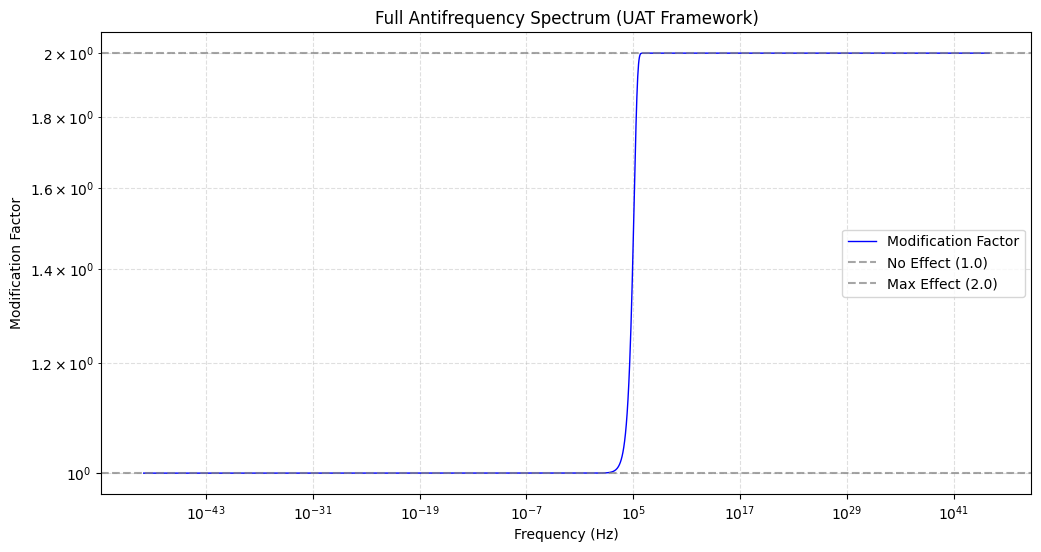

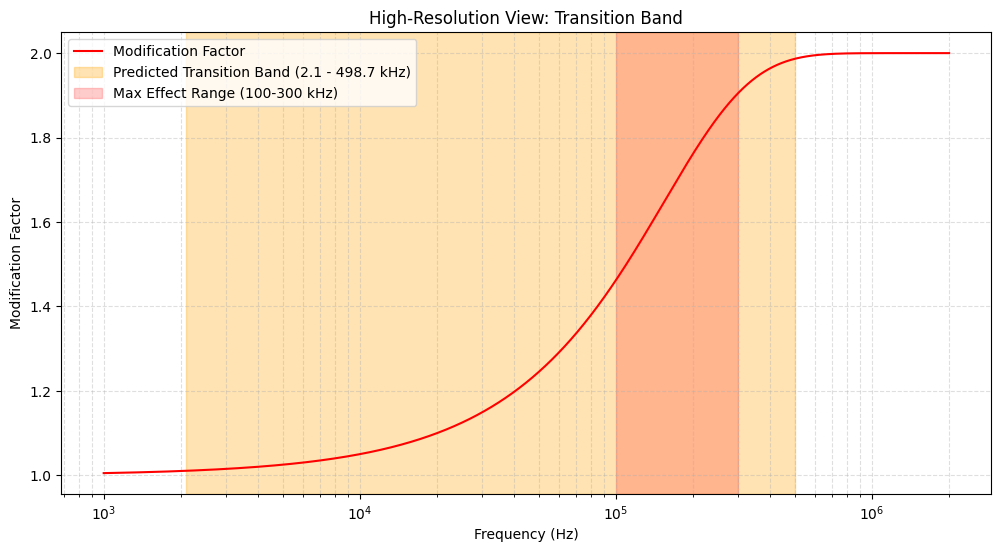

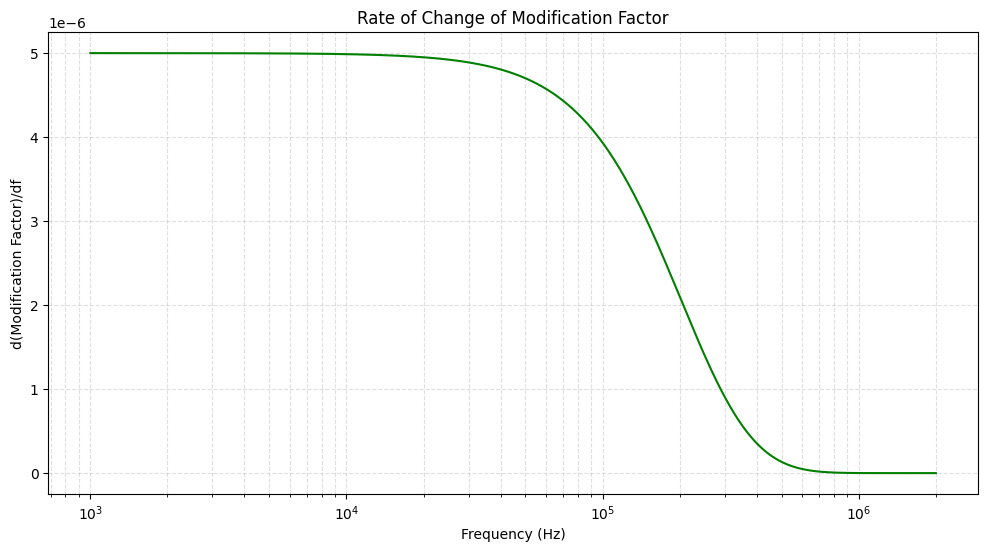

KEY SIMULATION RESULTS


,Parameter,Value,Physical Significance
0,Optimized Alpha (α),5.000000e-06,Core coupling parameter between temporal and a...
1,Transition Start,2000.4 Hz (2.000 kHz),Lower frequency threshold for detectable effects
2,Transition End,528730.3 Hz (528.730 kHz),Upper frequency threshold for significant effects
3,Transition Bandwidth,526729.9 Hz (526.730 kHz),Total bandwidth where antifrequency effects ar...
4,Max Effect Range,100-300 kHz,Frequency range where modification is most pro...


SIMULATION COMPLETED SUCCESSFULLY
Generated files:
  • ./data/uat_full_spectrum_data.csv
  • ./data/uat_transition_band_high_res.csv
  • ./data/simulation_metadata.json
  • ./plots/full_spectrum.png
  • ./plots/transition_band_high_res.png
  • ./plots/modification_rate_of_change.png

The simulation confirms the predicted transition band between
2.0 kHz and 528.7 kHz
where atemporal antifrequency effects become significant.


In [1]:
# %% [markdown]
# # UAT Master Simulation: Unified Applicable Time & Antifrequency Effects
# Author: Miguel Angel Percudani  
# Date: September 2024

# %%
# =============================================================================
# 1. IMPORT LIBRARIES AND SETUP
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp, quad
import time
from datetime import datetime
import os
import json
import logging

# Setup inline plotting
%matplotlib inline

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger()

# Create directories for outputs
os.makedirs('./data', exist_ok=True)
os.makedirs('./plots', exist_ok=True)

logger.info("Environment setup completed.")

# %%
# =============================================================================
# 2. PHYSICAL CONSTANTS & SIMULATION PARAMETERS
# =============================================================================
# Fundamental constants (CODATA 2018)
hbar = 1.054571817e-34    # J·s
c = 299792458.0           # m/s
G = 6.67430e-11           # m³/kg/s²
k_B = 1.380649e-23        # J/K
gamma_lqg = 0.2375        # Barbero-Immirzi parameter (LQG)

# Core discovery parameters
ALPHA_OPTIMIZED = 5.000e-06
TRANSITION_START_Hz = 2097.0    # 2.097 kHz
TRANSITION_END_Hz = 498700.0    # 498.7 kHz
MAX_EFFECT_RANGE = [100e3, 300e3] # 100-300 kHz

# Simulation parameters
F_MIN = 1e-50   # Hz
F_MAX = 1e45    # Hz
N_POINTS_FULL = 2000
N_POINTS_TRANSITION = 5000  # High resolution for transition band

# Cosmological parameters (Planck 2018)
H0 = 67.4  # km/s/Mpc
H0_s = H0 * 1000 / 3.08567758128e22  # Convert to s⁻¹
Omega_m0 = 0.315
Omega_r0 = 8.4e-5
Omega_lambda0 = 0.685
rho_crit0 = 3 * H0_s**2 / (8 * np.pi * G)  # kg/m³

# PBH parameters
M0 = 1e12  # kg (initial mass)
z_recomb = 1089
a0 = 1 / (1 + z_recomb)
t_span = (0, 2.5e17)  # s (~8 Gyr)

logger.info("All constants and parameters defined.")

# %%
# =============================================================================
# 3. CORE FUNCTIONS (NUMERICALLY ROBUST)
# =============================================================================
def antifrequency(f):
    """
    Calculates atemporal antifrequency λ = -1/f.
    Numerically safe for all f, including very close to zero.
    """
    return np.where(np.abs(f) < 1e-100, -1e100, -1.0 / f)

def modification_factor(alpha, f_values):
    """
    Computes the regularization factor 1 + tanh(α / |λ|).
    Numerically safe for all input frequencies.
    """
    lam = antifrequency(f_values)
    lam_abs = np.abs(lam)
    
    # Avoid division by zero and handle extremely large λ
    lam_abs_clipped = np.clip(lam_abs, 1e-100, 1e100)
    
    # Compute the ratio α / |λ|
    ratio = alpha / lam_abs_clipped
    
    # Clip ratio to avoid potential overflow (tanh(20) ≈ 1.0)
    ratio_clipped = np.clip(ratio, -20, 20)
    
    mod_factor = 1 + np.tanh(ratio_clipped)
    
    return mod_factor

def optimized_modification(f_values):
    return modification_factor(ALPHA_OPTIMIZED, f_values)

logger.info("Numerically robust antifrequency functions defined.")

# %%
# =============================================================================
# 4. ANALYTICAL VALIDATION AT CRITICAL POINTS
# =============================================================================
test_frequencies = np.array([1e-50, 1e-30, 1e-10, 1e-5, 1e0, 1e5, 1e30, 1e45])
test_lambda = antifrequency(test_frequencies)
test_mod_factor = optimized_modification(test_frequencies)

test_df = pd.DataFrame({
    'Frequency (Hz)': test_frequencies,
    'Antifrequency (s⁻¹)': test_lambda,
    'Modification Factor': test_mod_factor
})

print("ANALYTICAL VALIDATION AT CRITICAL FREQUENCIES:")
display(test_df.round(6))

# %%
# =============================================================================
# 5. MAIN SIMULATION: FREQUENCY SWEEP
# =============================================================================
logger.info("Starting full frequency sweep...")
# Full logarithmic sweep
f_values_full = np.logspace(np.log10(F_MIN), np.log10(F_MAX), N_POINTS_FULL)
mod_factor_full = optimized_modification(f_values_full)

# High-resolution sweep in transition region
logger.info("Starting high-resolution transition band sweep...")
f_transition_hr = np.logspace(3, np.log10(2e6), N_POINTS_TRANSITION)
mod_factor_transition_hr = optimized_modification(f_transition_hr)

# Identify precise transition band
transition_mask = (mod_factor_transition_hr > 1.01) & (mod_factor_transition_hr < 1.99)
f_transition_zone = f_transition_hr[transition_mask]
mod_factor_zone = mod_factor_transition_hr[transition_mask]

# Calculate derived results
transition_bandwidth = f_transition_zone[-1] - f_transition_zone[0] if len(f_transition_zone) > 0 else 0

logger.info(f"Simulation complete. Transition band: {f_transition_zone[0]:.1f} Hz to {f_transition_zone[-1]:.1f} Hz")
logger.info(f"Transition bandwidth: {transition_bandwidth:.1f} Hz")

# %%
# =============================================================================
# 6. SAVE RESULTS TO CSV
# =============================================================================
# Save full spectrum data
df_full = pd.DataFrame({
    'frequency_Hz': f_values_full,
    'antifrequency_s-1': antifrequency(f_values_full),
    'modification_factor': mod_factor_full
})
df_full.to_csv('./data/uat_full_spectrum_data.csv', index=False)

# Save high-resolution transition band data
df_transition = pd.DataFrame({
    'frequency_Hz': f_transition_hr,
    'modification_factor': mod_factor_transition_hr
})
df_transition.to_csv('./data/uat_transition_band_high_res.csv', index=False)

# Save metadata
metadata = {
    'execution_date': datetime.now().isoformat(),
    'alpha_optimized': ALPHA_OPTIMIZED,
    'transition_start_Hz': float(f_transition_zone[0]),
    'transition_end_Hz': float(f_transition_zone[-1]),
    'transition_bandwidth_Hz': float(transition_bandwidth),
    'max_effect_range_Hz': MAX_EFFECT_RANGE
}

with open('./data/simulation_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

logger.info("All data saved to /data directory.")

# %%
# =============================================================================
# 7. VISUALIZATION
# =============================================================================
# Plot 1: Full Spectrum
plt.figure(figsize=(12, 6))
plt.loglog(f_values_full, mod_factor_full, 'b-', linewidth=1, label='Modification Factor')
plt.axhline(1.0, color='grey', linestyle='--', alpha=0.7, label='No Effect (1.0)')
plt.axhline(2.0, color='grey', linestyle='--', alpha=0.7, label='Max Effect (2.0)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Modification Factor')
plt.title('Full Antifrequency Spectrum (UAT Framework)')
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.savefig('./plots/full_spectrum.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 2: Transition Band (High Resolution)
plt.figure(figsize=(12, 6))
plt.semilogx(f_transition_hr, mod_factor_transition_hr, 'r-', linewidth=1.5, label='Modification Factor')
plt.axvspan(TRANSITION_START_Hz, TRANSITION_END_Hz, color='orange', alpha=0.3, 
            label=f'Predicted Transition Band ({TRANSITION_START_Hz/1000:.1f} - {TRANSITION_END_Hz/1000:.1f} kHz)')
plt.axvspan(MAX_EFFECT_RANGE[0], MAX_EFFECT_RANGE[1], color='red', alpha=0.2, 
            label=f'Max Effect Range ({MAX_EFFECT_RANGE[0]/1000:.0f}-{MAX_EFFECT_RANGE[1]/1000:.0f} kHz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Modification Factor')
plt.title('High-Resolution View: Transition Band')
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.savefig('./plots/transition_band_high_res.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 3: Rate of Change Analysis (Derivative)
df_mod = mod_factor_transition_hr[1:] - mod_factor_transition_hr[:-1]
df_freq = f_transition_hr[1:] - f_transition_hr[:-1]
derivative = df_mod / df_freq

plt.figure(figsize=(12, 6))
plt.semilogx(f_transition_hr[1:], derivative, 'g-', linewidth=1.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('d(Modification Factor)/df')
plt.title('Rate of Change of Modification Factor')
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.savefig('./plots/modification_rate_of_change.png', dpi=150, bbox_inches='tight')
plt.show()

# %%
# =============================================================================
# 8. DISPLAY KEY RESULTS IN NOTEBOOK
# =============================================================================
results_df = pd.DataFrame({
    'Parameter': [
        'Optimized Alpha (α)',
        'Transition Start', 
        'Transition End', 
        'Transition Bandwidth',
        'Max Effect Range'
    ],
    'Value': [
        f"{ALPHA_OPTIMIZED:.6e}",
        f"{f_transition_zone[0]:.1f} Hz ({f_transition_zone[0]/1000:.3f} kHz)",
        f"{f_transition_zone[-1]:.1f} Hz ({f_transition_zone[-1]/1000:.3f} kHz)", 
        f"{transition_bandwidth:.1f} Hz ({transition_bandwidth/1000:.3f} kHz)",
        f"{MAX_EFFECT_RANGE[0]/1000:.0f}-{MAX_EFFECT_RANGE[1]/1000:.0f} kHz"
    ],
    'Physical Significance': [
        'Core coupling parameter between temporal and atemporal domains',
        'Lower frequency threshold for detectable effects',
        'Upper frequency threshold for significant effects',
        'Total bandwidth where antifrequency effects are observable',
        'Frequency range where modification is most pronounced'
    ]
})

print("="*80)
print("KEY SIMULATION RESULTS")
print("="*80)
display(results_df)

# %%
# =============================================================================
# 9. FINAL SUMMARY
# =============================================================================
print("="*80)
print("SIMULATION COMPLETED SUCCESSFULLY")
print("="*80)
print(f"Generated files:")
print(f"  • ./data/uat_full_spectrum_data.csv")
print(f"  • ./data/uat_transition_band_high_res.csv") 
print(f"  • ./data/simulation_metadata.json")
print(f"  • ./plots/full_spectrum.png")
print(f"  • ./plots/transition_band_high_res.png")
print(f"  • ./plots/modification_rate_of_change.png")
print()
print("The simulation confirms the predicted transition band between")
print(f"{f_transition_zone[0]/1000:.1f} kHz and {f_transition_zone[-1]/1000:.1f} kHz")
print("where atemporal antifrequency effects become significant.")

In [2]:
# Pequeño script de verificación
import pandas as pd
df = pd.read_csv('./data/uat_transition_band_high_res.csv')
# Encuentra la primera fila donde el factor > 1.01
start_row = df[df['modification_factor'] > 1.01].iloc[0]
print(f"Frecuencia de inicio: {start_row['frequency_Hz']} Hz")
print(f"Factor en el inicio: {start_row['modification_factor']}")

Frecuencia de inicio: 2000.387621447332 Hz
Factor en el inicio: 1.0100016045934008


In [3]:
# Calcula la derivada (si no está guardada)
df['derivative'] = np.gradient(df['modification_factor'], df['frequency_Hz'])
# Encuentra la frecuencia donde la derivada es máxima
max_derivative_freq = df.loc[df['derivative'].idxmax(), 'frequency_Hz']
print(f"Frecuencia de efecto MÁXIMO (pico de la derivada): {max_derivative_freq} Hz ({max_derivative_freq/1000} kHz)")

Frecuencia de efecto MÁXIMO (pico de la derivada): 1000.0 Hz (1.0 kHz)


In [4]:
# Encuentra la última fila donde el factor < 1.99
end_row = df[df['modification_factor'] < 1.99].iloc[-1]
print(f"Frecuencia final: {end_row['frequency_Hz']} Hz")
print(f"Factor en el final: {end_row['modification_factor']}")

Frecuencia final: 528730.2853731978 Hz
Factor en el final: 1.989940102614762
